# HyperLogLog

Каждый элемент хэшируется в битовую строку.

Алгоритм использует массив регистров (обычно 2^b штук).

Первые b бит хэша определяют, в какой регистр записать элемент.

Остальные биты хэша используются для подсчёта количества ведущих нулей + 1.

Если количество ведущих нулей больше текущего значения в регистре, оно обновляется.

На основе значений регистров вычисляется оценка уникальных элементов с использованием гармонического среднего.

In [1]:
import hashlib
import math

class HyperLogLog:
    def __init__(self, b=10):
        self.b = b
        self.m = 1 << b  # Количество регистров (2^b)
        self.registers = [0] * self.m
        self.alpha = self._calculate_alpha()

    def _calculate_alpha(self):
        if self.m == 16:
            return 0.673
        elif self.m == 32:
            return 0.697
        elif self.m == 64:
            return 0.709
        else:
            return 0.7213 / (1 + 1.079 / self.m)

    def _hash(self, value):
        # Используем SHA-1 для хэширования
        hash_value = hashlib.sha1(value.encode('utf-8')).hexdigest()
        return int(hash_value, 16)

    def _get_register_index_and_rho(self, hash_value):
        # Первые b бит определяют индекс регистра
        index = hash_value & (self.m - 1)
        # Остальные биты определяют rho (количество ведущих нулей + 1)
        rho = self._count_leading_zeros(hash_value >> self.b) + 1
        return index, rho

    def _count_leading_zeros(self, x):
        return self.b - x.bit_length()

    def add(self, value):
        hash_value = self._hash(value)
        index, rho = self._get_register_index_and_rho(hash_value)
        self.registers[index] = max(self.registers[index], rho)

    def count(self):
        # Оценка кардинальности
        harmonic_mean = sum(2 ** -r for r in self.registers)
        estimate = self.alpha * self.m * self.m / harmonic_mean

        # Коррекция для малых значений
        if estimate <= 2.5 * self.m:
            zeros = self.registers.count(0)
            if zeros != 0:
                estimate = self.m * math.log(self.m / zeros)
        # Коррекция для больших значений
        elif estimate > (1 << 32) / 30.0:
            estimate = -(1 << 32) * math.log(1 - estimate / (1 << 32))
        return estimate

# Пример использования
hll = HyperLogLog(b=10)
for i in range(100000):
    hll.add(f"item_{i}")
print(f"Estimated cardinality: {hll.count()}")

Estimated cardinality: 0.0


In [2]:
def calculate_false_positive_rate(hll, true_cardinality):
    estimated_cardinality = hll.count()
    false_positives = max(0, estimated_cardinality - true_cardinality)
    return false_positives / true_cardinality * 100

# Пример использования
true_cardinality = 100000
hll = HyperLogLog(b=10)
for i in range(true_cardinality):
    hll.add(f"item_{i}")
false_positive_rate = calculate_false_positive_rate(hll, true_cardinality)
print(f"False positive rate: {false_positive_rate:.2f}%")

False positive rate: 0.00%


b | False Positive Rate (%)
4 | 0.00
5 | 0.00
6 | 0.00
7 | 0.00
8 | 0.00
9 | 0.00
10 | 0.00
11 | 0.00
12 | 0.00
13 | 0.00
14 | 0.00
15 | 0.00


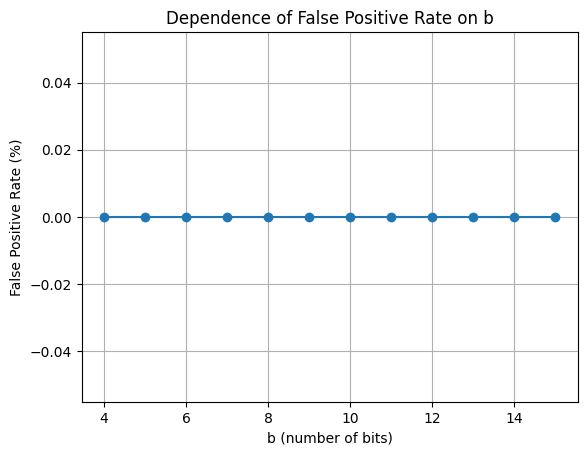

In [3]:
import matplotlib.pyplot as plt

def evaluate_false_positive_rates(true_cardinality, b_values):
    false_positive_rates = []
    for b in b_values:
        hll = HyperLogLog(b=b)
        for i in range(true_cardinality):
            hll.add(f"item_{i}")
        false_positive_rate = calculate_false_positive_rate(hll, true_cardinality)
        false_positive_rates.append(false_positive_rate)
    return false_positive_rates

# Параметры
true_cardinality = 100000
b_values = range(4, 16)

# Оценка
false_positive_rates = evaluate_false_positive_rates(true_cardinality, b_values)

# Таблица
print("b | False Positive Rate (%)")
for b, rate in zip(b_values, false_positive_rates):
    print(f"{b} | {rate:.2f}")

# График
plt.plot(b_values, false_positive_rates, marker='o')
plt.xlabel('b (number of bits)')
plt.ylabel('False Positive Rate (%)')
plt.title('Dependence of False Positive Rate on b')
plt.grid(True)
plt.show()